# GROUP 3 - TENSORFLOW PROJECT 2 - BRAIN TUMOR ANOMALY DETECTION
# MEMBERS:
## LAM TRINH DINH
## WILLIAM NGO
## PEYTON CAMPBELL
## PRUTHVI MARE

## Libraries

In [22]:
import kagglehub
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import pandas as pd


## Loading dataset

In [2]:
#download dataset
path = kagglehub.dataset_download("jakeshbohaju/brain-tumor")
print("Path to dataset files:", path)

#move dataset to content folder
colab_content_dir = "/content/brain-tumor-dataset"

if not os.path.exists(colab_content_dir):
    os.makedirs(colab_content_dir)

for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join(colab_content_dir, item)
    if os.path.isdir(source):
        if os.path.exists(destination):
            shutil.rmtree(destination)
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)
print(f"Moved dataset files to: {colab_content_dir}")


100%|██████████| 14.0M/14.0M [00:01<00:00, 7.68MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jakeshbohaju/brain-tumor/versions/3
Moved dataset files to: /content/brain-tumor-dataset


In [25]:
import pandas as pd
df = pd.read_csv("/content/brain-tumor-dataset/Brain Tumor.csv")
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [23]:
df['Class'].value_counts()


,count
Class,
0,2079
1,1683


## Class distribution

<ipython-input-28-7838effe8039>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2', alpha=0.7)  # 'Set2' provides multiple colors


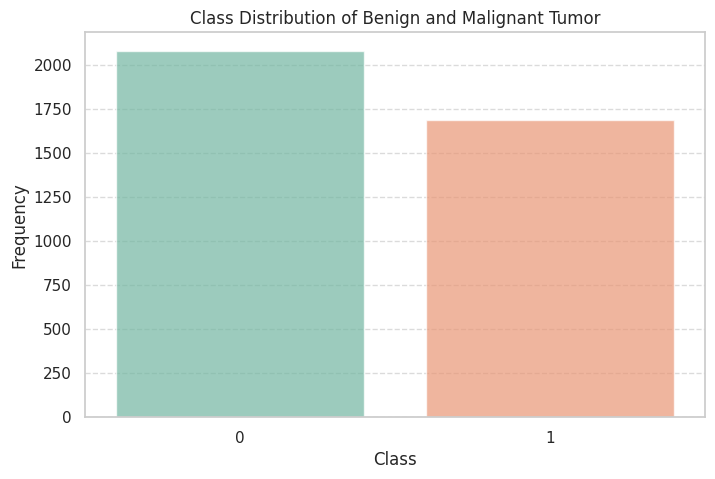

Class Distribution:
Class
0    2079
1    1683
Name: count, dtype: int64


In [28]:


# Plot with seaborn
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df, palette='Set2', alpha=0.7)  # 'Set2' provides multiple colors
plt.title('Class Distribution of Benign and Malignant Tumor')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Class Distribution:")
print(df['Class'].value_counts())

## Loading samples

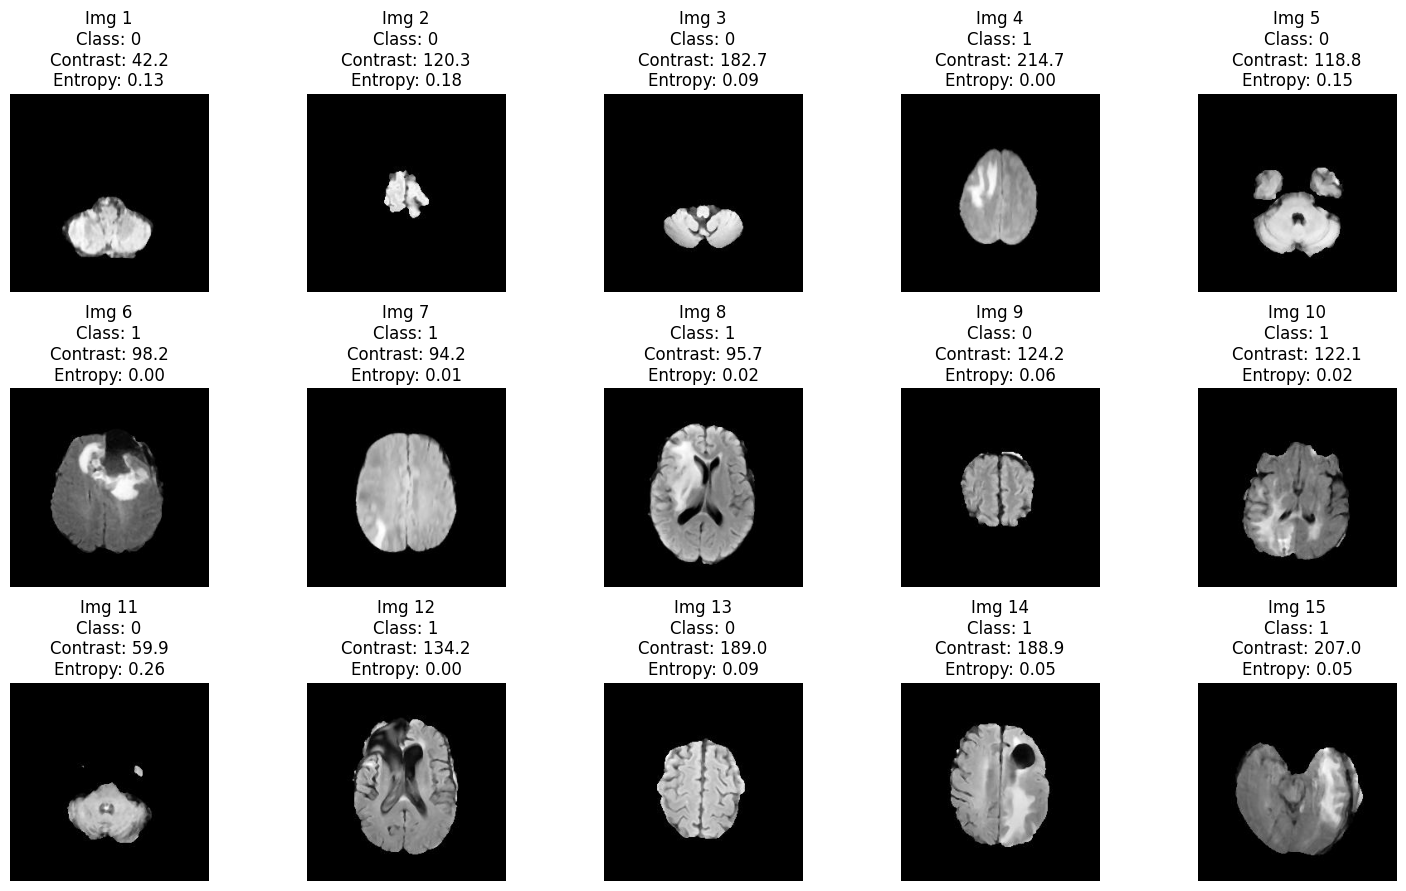

In [4]:
#images folder
image_folder = "/content/brain-tumor-dataset/Brain Tumor/Brain Tumor/"

#load image function
def load_images_with_features(folder_path, dataframe, num_images_to_show=15):
    images = []
    features = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if i >= num_images_to_show:
            break
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path) and filename.endswith('.jpg'):
            # Load image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            images.append(img_array)
            # Match with CSV (assuming 'Image' column has filenames)
            img_name = filename.split('.')[0]  # Remove .jpg extension
            row = dataframe[dataframe['Image'] == img_name]
            if not row.empty:
                features.append(row.iloc[0])
            else:
                features.append(None)  # If no match found
    return images, features

#load 15 images
num_images_to_show = 15
images, features = load_images_with_features(image_folder, df, num_images_to_show)

# plot with attributes
if images:
    plt.figure(figsize=(15, 9))
    for i in range(min(num_images_to_show, len(images))):
        row = i // 5
        col = i % 5
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        #add title with Class
        if features[i] is not None:
            title = (f"Img {i+1}\nClass: {features[i]['Class']}\n"
                    f"Contrast: {features[i]['Contrast']:.1f}\n"
                    f"Entropy: {features[i]['Entropy']:.2f}")
        else:
            title = f"Img {i+1}\n(No data)"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images loaded.")

## Splitting data

In [6]:
# load images
def load_images_from_folder(folder_path, image_names):
    images = []
    for filename in image_names:
        img_path = os.path.join(folder_path, filename + '.jpg')
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert('L')
            img = img.resize((128, 128))
            img_array = np.array(img) / 255.0
            images.append(img_array)
    return np.array(images)

# Separate Class 0 and Class 1 based on CSV
class_0_df = df[df['Class'] == 0]
class_1_df = df[df['Class'] == 1]

# Train set: 1500 Class 0
train_df = class_0_df.sample(n=1500, random_state=42)  # Randomly select 1500 Class 0
train_images = load_images_from_folder(image_folder, train_df['Image'])
train_labels = np.zeros(len(train_images))  # All Class 0

# Test set: 579 Class 0 (remaining) + 570 Class 1
remaining_class_0_df = class_0_df.drop(train_df.index)  # 579 remaining Class 0
test_class_0_df = remaining_class_0_df  # All 579
test_class_1_df = class_1_df.sample(n=570, random_state=42)  # 570 Class 1

# Load test images
test_class_0_images = load_images_from_folder(image_folder, test_class_0_df['Image'])
test_class_1_images = load_images_from_folder(image_folder, test_class_1_df['Image'])

# Combine test set
test_images = np.concatenate([test_class_0_images, test_class_1_images])
test_labels = np.concatenate([np.zeros(len(test_class_0_images)), np.ones(len(test_class_1_images))])

# Reshape for model input
train_images = train_images.reshape(-1, 128, 128, 1)
test_images = test_images.reshape(-1, 128, 128, 1)

# Print shapes and label distribution
print(f"Total images loaded: {len(df)}")  # Should be 3762
print(f"Training images (Class 0): {train_images.shape}")
print(f"Testing images (mixed): {test_images.shape}, Labels: {test_labels.shape}")
print("Test label distribution:", np.bincount(test_labels.astype(int)))

Total images loaded: 3762
Training images (Class 0): (1500, 128, 128, 1)
Testing images (mixed): (1149, 128, 128, 1), Labels: (1149,)
Test label distribution: [579 570]


# Autoencoder

GPUs available: 1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

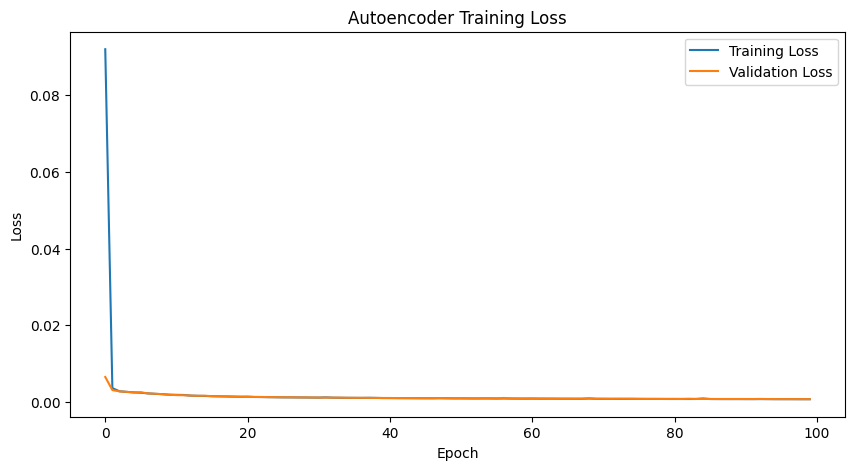

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [7]:
#gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU: {gpu}")
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, running on CPU.")

#Autoencoder
input_img = layers.Input(shape=(128, 128, 1))

#Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

#Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#initialization
autoencoder = models.Model(input_img, decoded)

#optimizer
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#summary
autoencoder.summary()

#split training set 80% for train and 20% for validation
train_data, val_data = train_test_split(train_images, test_size=0.2, random_state=42)

#create tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

#create tf.data.Dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#train autoencoder with class 0
with tf.device('/GPU:0'):
    history = autoencoder.fit(train_dataset,
                              epochs=100,
                              validation_data=val_dataset,
                              callbacks=[TqdmCallback(verbose=1)],
                              verbose=0)

#training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#prediction
test_predictions = autoencoder.predict(test_images)

#reconstruction error per images
reconstruction_errors = np.mean((test_images - test_predictions) ** 2, axis=(1, 2, 3))

#separate errors by true class (using test_labels)
class_0_errors = reconstruction_errors[test_labels == 0]  # 579 Class 0
class_1_errors = reconstruction_errors[test_labels == 1]  # 570 Class 1

## Autoencoder reconstruction error distribution

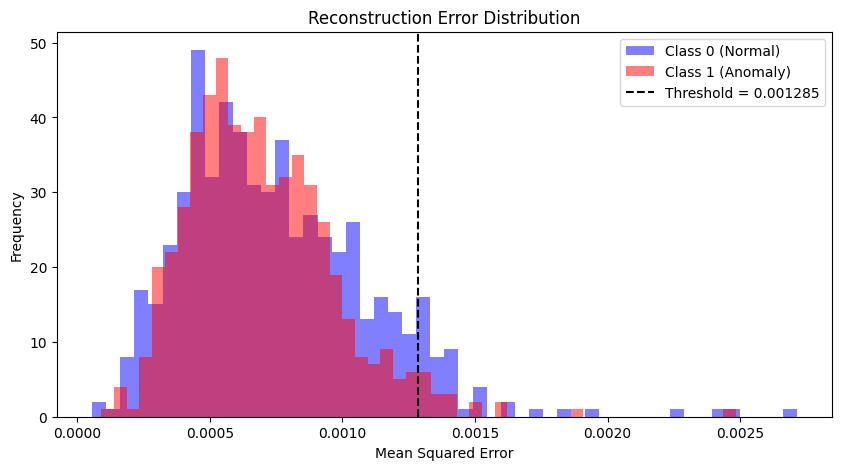

In [8]:
#reconstruction errors distribution
threshold = np.mean(class_0_errors) + 1.5 * np.std(class_0_errors)
plt.figure(figsize=(10, 5))
plt.hist(class_0_errors, bins=50, alpha=0.5, label='Class 0 (Normal)', color='blue')
plt.hist(class_1_errors, bins=50, alpha=0.5, label='Class 1 (Anomaly)', color='red')
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.6f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

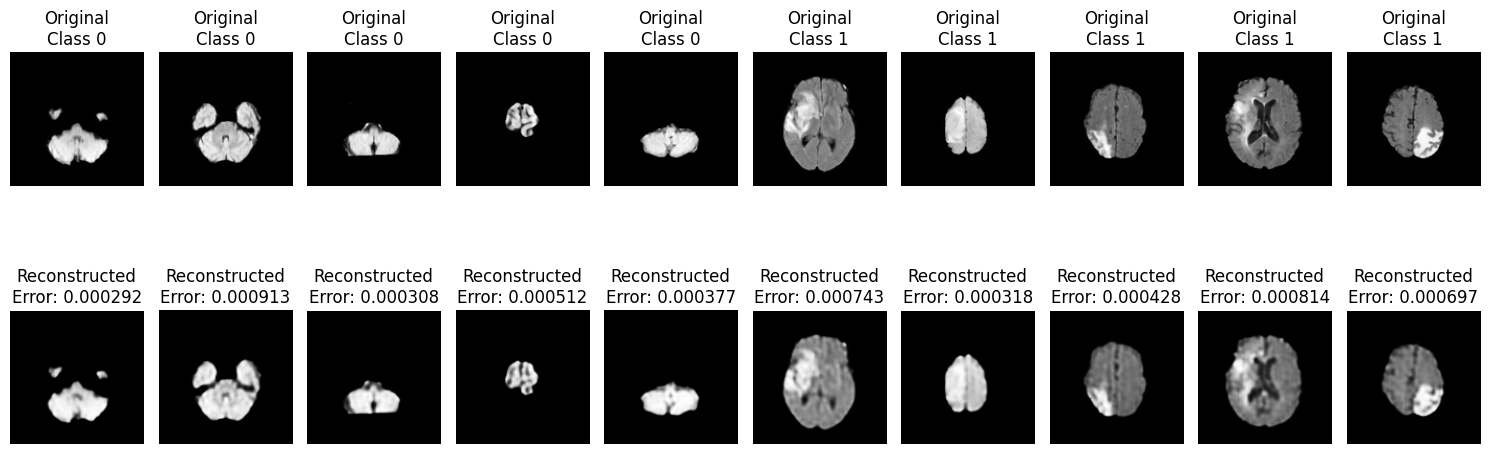

In [9]:
#reconstruction error for 5 images of each class
num_examples = 5
class_0_indices = np.where(test_labels == 0)[0][:num_examples]
class_1_indices = np.where(test_labels == 1)[0][:num_examples]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.concatenate([class_0_indices, class_1_indices])):
    plt.subplot(2, num_examples * 2, i + 1)
    plt.imshow(test_images[idx].reshape(128, 128), cmap='gray')
    plt.title(f"Original\nClass {int(test_labels[idx])}")
    plt.axis('off')

    plt.subplot(2, num_examples * 2, i + 1 + num_examples * 2)
    plt.imshow(test_predictions[idx].reshape(128, 128), cmap='gray')
    plt.title(f"Reconstructed\nError: {reconstruction_errors[idx]:.6f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Adjusting threshold 1-100% for accuracy




36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Evaluating Thresholds: 100%|██████████| 100/100 [00:00<00:00, 347.86it/s]



=== All Results ===

=== Best Result ===
Best Percentile: 4%
Threshold: 0.000273
Accuracy: 0.5117
Confusion Matrix:
[[ 29 550]
 [ 11 559]]


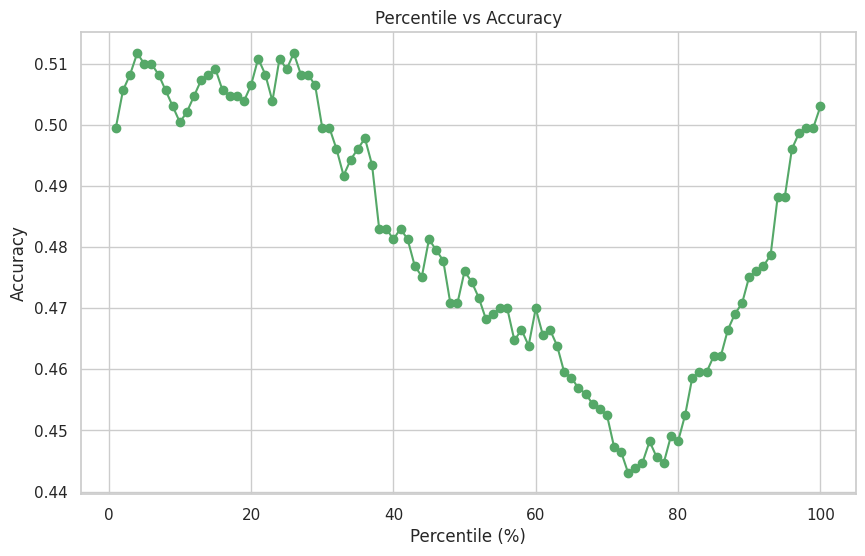

In [37]:
#reconstruct test images
reconstructed_images = autoencoder.predict(test_images)

#compute reconstruction error (MSE) for each image
mse = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

#compute training MSE for threshold calculation
train_reconstructed = autoencoder.predict(train_images)
train_mse = np.mean(np.square(train_images - train_reconstructed), axis=(1, 2, 3))

#dictionary to store threshold and accuracy results
results = {}

#test thresholds from 1% to 100%
for i in tqdm(range(100), desc="Evaluating Thresholds"):
    percentile = 1 + i
    threshold = np.percentile(train_mse, percentile)  # Percentile of Class 0 errors

    # Classify test images as normal (0) or anomalous (1) based on threshold
    predictions = (mse > threshold).astype(int)

    # Evaluate performance
    accuracy = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)

    # Store results
    results[percentile] = {
        'threshold': threshold,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix
    }

# After all iterations, print all results and find the best one
print("\n=== All Results ===")
best_percentile = None
best_accuracy = -1
for percentile, result in results.items():
    if result['accuracy'] > best_accuracy:
        best_accuracy = result['accuracy']
        best_percentile = percentile

print("\n=== Best Result ===")
print(f"Best Percentile: {best_percentile}%")
print(f"Threshold: {results[best_percentile]['threshold']:.6f}")
print(f"Accuracy: {results[best_percentile]['accuracy']:.4f}")
print(f"Confusion Matrix:\n{results[best_percentile]['conf_matrix']}")

# Plot percentile vs accuracy
percentiles_ae = list(results.keys())  # [1, 2, ..., 100]
accuracies_ae = [results[p]['accuracy'] for p in results]

plt.figure(figsize=(10, 6))
plt.plot(percentiles_ae, accuracies_ae, marker='o', linestyle='-', color='g')
plt.title('Percentile vs Accuracy')
plt.xlabel('Percentile (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Best result from Autoencoder

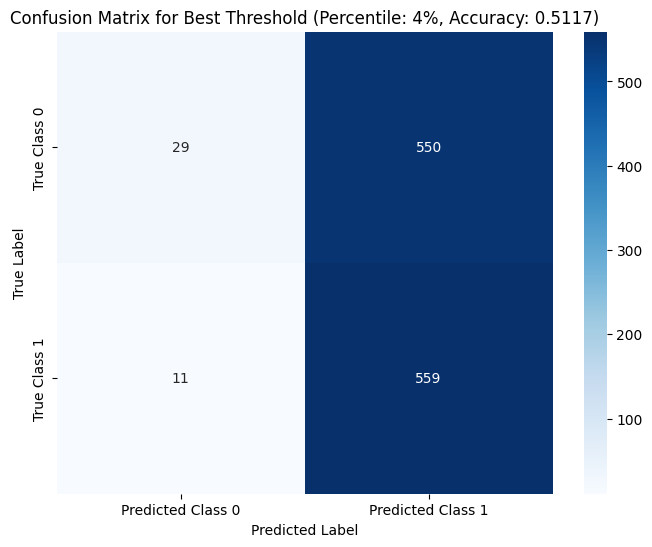

In [11]:
import seaborn as sns
# Generate heatmap for the best result's confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(results[best_percentile]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Class 0', 'Predicted Class 1'],
            yticklabels=['True Class 0', 'True Class 1'])
plt.title(f'Confusion Matrix for Best Threshold (Percentile: {best_percentile}%, Accuracy: {best_accuracy:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Variational Autoencoder

GPUs available: 1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

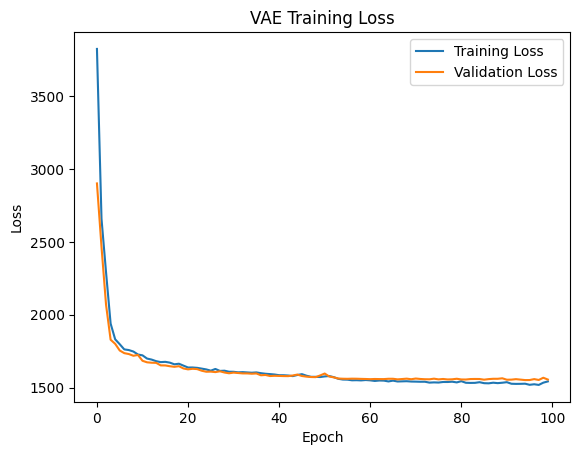

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Reconstruction error threshold: 0.005066


In [13]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU: {gpu}")
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, running on CPU.")

# Custom VAE layer for sampling
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), dtype=tf.float16)
        return z_mean + tf.cast(tf.exp(tf.cast(0.5 * z_log_var, tf.float16)), tf.float16) * epsilon

# VAE parameters
latent_dim = 64  # Increased latent space size
input_shape = (128, 128, 1)

# Encoder (deeper)
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Added layer
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder (deeper)
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 256)(latent_inputs)  # Adjusted for deeper encoder
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = models.Model(latent_inputs, outputs, name='decoder')

# VAE model
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs, training=None):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, reconstruction), axis=[1, 2]))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.1 * kl_loss  # Reduced KL weight
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, reconstruction), axis=[1, 2]))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 0.1 * kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate and compile VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Use mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Split train_images into training and validation
train_data, val_data = train_test_split(train_images, test_size=0.2, random_state=42)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the VAE on Class 0
with tf.device('/GPU:0'):
    history = vae.fit(train_dataset,
                      epochs=100,  # Increased epochs
                      validation_data=val_dataset,
                      callbacks=[TqdmCallback(verbose=1)],
                      verbose=0)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict reconstructions for test set
_, _, z = encoder.predict(test_images)
test_predictions = decoder.predict(z)

# Compute reconstruction errors
reconstruction_errors = np.mean((test_images - test_predictions) ** 2, axis=(1, 2, 3))

# Separate errors by class
class_0_errors = reconstruction_errors[test_labels == 0]  # 579
class_1_errors = reconstruction_errors[test_labels == 1]  # 570

# Set threshold (tighter)
threshold = np.mean(class_0_errors) + 1.5 * np.std(class_0_errors)  # Adjusted to 1.5*std
print(f"Reconstruction error threshold: {threshold:.6f}")

# Classify
predicted_labels = (reconstruction_errors > threshold).astype(int)


## VAE reconstruction error distribution

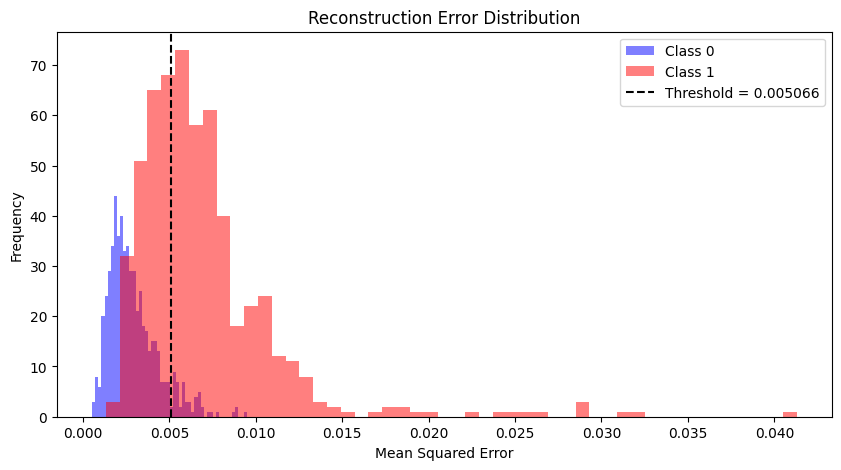

In [14]:
# Plot error distribution for insight
plt.figure(figsize=(10, 5))
plt.hist(class_0_errors, bins=50, alpha=0.5, label='Class 0', color='blue')
plt.hist(class_1_errors, bins=50, alpha=0.5, label='Class 1', color='red')
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.6f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Anomaly detection threshold: 0.004146
Accuracy: 0.8172
Confusion Matrix:
[[480  99]
 [111 459]]


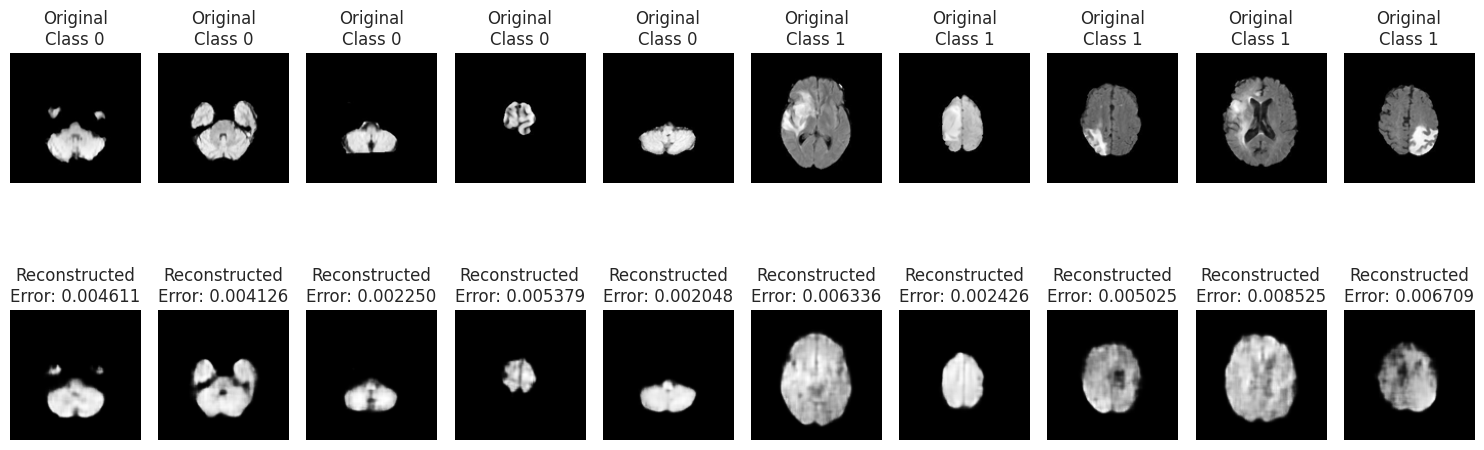

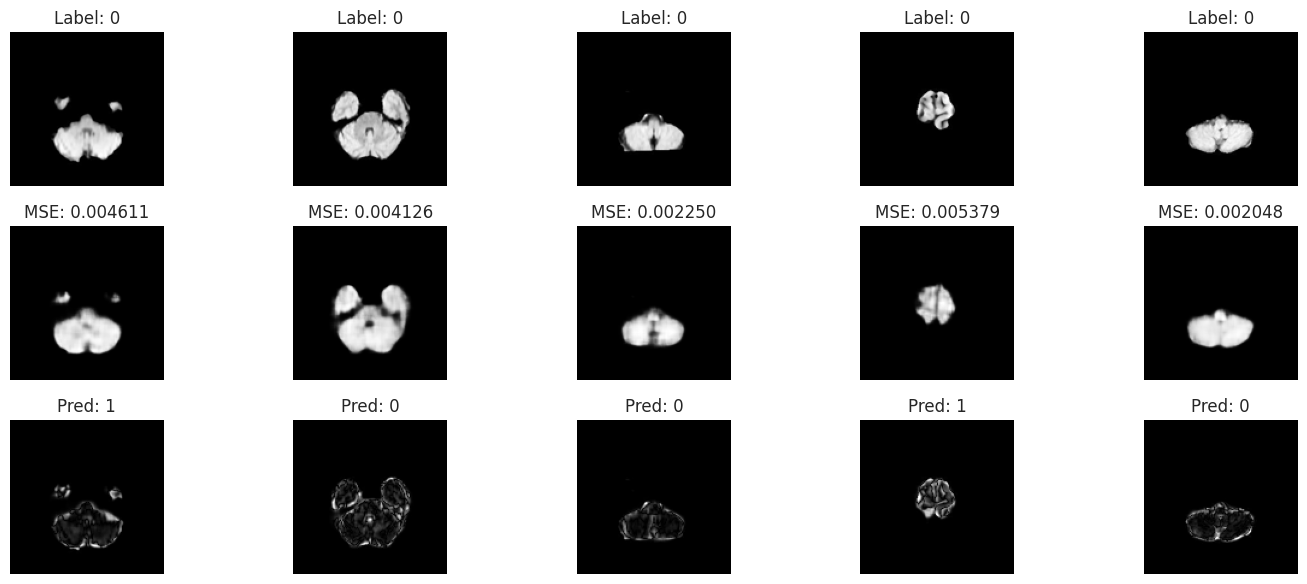

In [29]:


# Reconstruct test images using VAE's encoder and decoder
_, _, z = encoder.predict(test_images)  # Get latent representation
reconstructed_images = decoder.predict(z)  # Decode to reconstructions

# Compute reconstruction error (MSE) for each image
mse = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., 95th percentile of training error)
_, _, train_z = encoder.predict(train_images)  # Encode training data
train_reconstructed = decoder.predict(train_z)  # Decode training reconstructions
train_mse = np.mean(np.square(train_images - train_reconstructed), axis=(1, 2, 3))
threshold = np.percentile(train_mse, 95)  # 95th percentile of Class 0 errors
print(f"Anomaly detection threshold: {threshold:.6f}")

# Classify test images as normal (0) or anomalous (1) based on threshold
predictions = (mse > threshold).astype(int)

# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize example reconstructions (first 5 from each class)
num_examples = 5
class_0_indices = np.where(test_labels == 0)[0][:num_examples]
class_1_indices = np.where(test_labels == 1)[0][:num_examples]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.concatenate([class_0_indices, class_1_indices])):
    plt.subplot(2, num_examples * 2, i + 1)
    plt.imshow(test_images[idx].reshape(128, 128), cmap='gray')
    plt.title(f"Original\nClass {int(test_labels[idx])}")
    plt.axis('off')

    plt.subplot(2, num_examples * 2, i + 1 + num_examples * 2)
    plt.imshow(reconstructed_images[idx].reshape(128, 128), cmap='gray')
    plt.title(f"Reconstructed\nError: {mse[idx]:.6f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize some test images with their reconstruction and differences (first 5 test images)
num_samples = 5
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    # Original image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(test_images[i].reshape(128, 128), cmap='gray')
    plt.title(f"Label: {int(test_labels[i])}")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
    plt.title(f"MSE: {mse[i]:.6f}")
    plt.axis('off')

    # Difference
    plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(np.abs(test_images[i] - reconstructed_images[i]).reshape(128, 128), cmap='gray')
    plt.title(f"Pred: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Best accuracy from VAE

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating Thresholds: 100%|██████████| 100/100 [00:00<00:00, 526.90it/s]



=== All Results ===

=== Best Result ===
Best Percentile: 95%
Threshold: 0.004125
Accuracy: 0.8146
Confusion Matrix:
[[481  98]
 [115 455]]


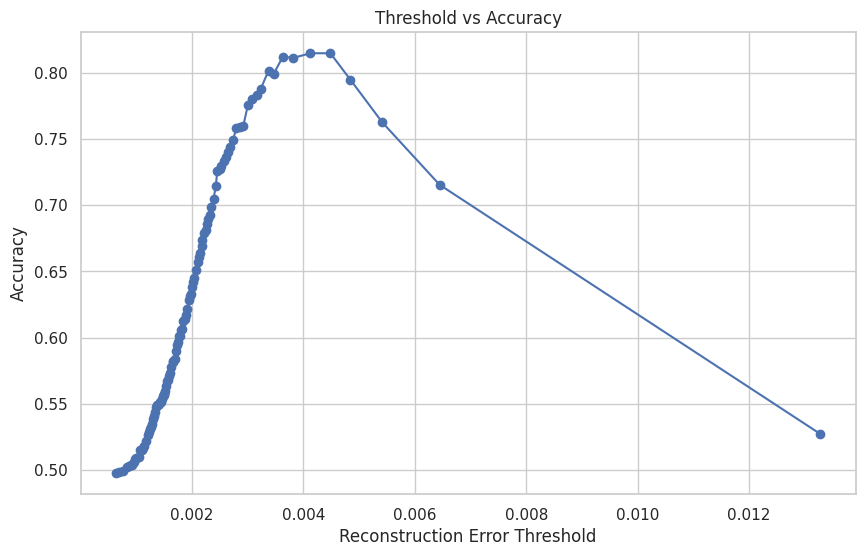

In [30]:
# Reconstruct test images using VAE's encoder and decoder
_, _, z = encoder.predict(test_images)  # Get latent representation
reconstructed_images = decoder.predict(z)  # Decode to reconstructions

# Compute reconstruction error (MSE) for each image
mse = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Compute training MSE for threshold calculation
_, _, train_z = encoder.predict(train_images)  # Encode training data
train_reconstructed = decoder.predict(train_z)  # Decode training reconstructions
train_mse = np.mean(np.square(train_images - train_reconstructed), axis=(1, 2, 3))

# Dictionary to store threshold and accuracy results
results = {}

# Iterate over percentiles from 1 to 100 with tqdm
for i in tqdm(range(100), desc="Evaluating Thresholds"):  # Add tqdm with a description
    percentile = 1 + i  # 1% to 100%
    threshold = np.percentile(train_mse, percentile)  # Percentile of Class 0 errors

    # Classify test images as normal (0) or anomalous (1) based on threshold
    predictions = (mse > threshold).astype(int)

    # Evaluate performance
    accuracy = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)

    # Store results
    results[percentile] = {
        'threshold': threshold,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'predictions': predictions  # Store predictions for the best result
    }


# After all iterations, print all results and find the best one
print("\n=== All Results ===")
best_percentile_vae = None
best_accuracy = -1
for percentile, result in results.items():
    if result['accuracy'] > best_accuracy:
        best_accuracy = result['accuracy']
        best_percentile_vae = percentile

print("\n=== Best Result ===")
print(f"Best Percentile: {best_percentile_vae}%")
print(f"Threshold: {results[best_percentile_vae]['threshold']:.6f}")
print(f"Accuracy: {results[best_percentile_vae]['accuracy']:.4f}")
print(f"Confusion Matrix:\n{results[best_percentile_vae]['conf_matrix']}")

# Plot threshold vs accuracy
thresholds = [results[p]['threshold'] for p in results]
accuracies = [results[p]['accuracy'] for p in results]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.title('Threshold vs Accuracy')
plt.xlabel('Reconstruction Error Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

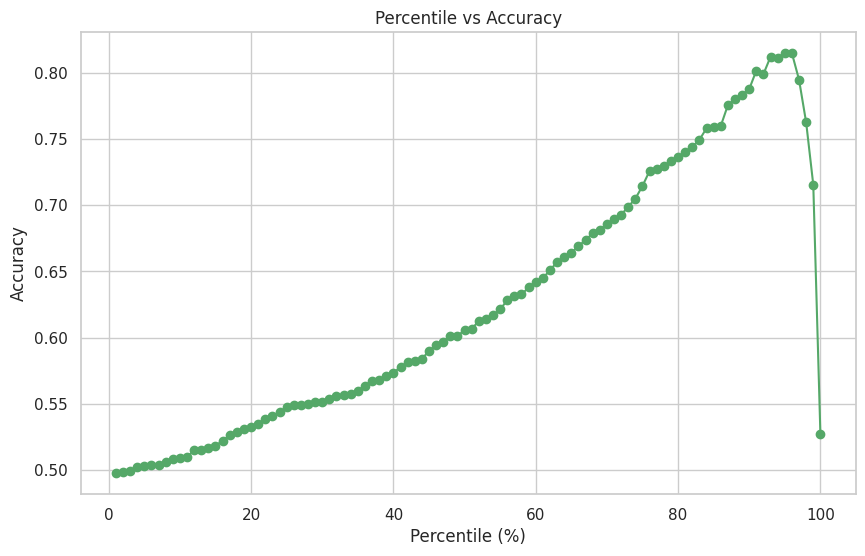

In [31]:
percentiles_vae = list(results.keys())  # [1, 2, ..., 100]
accuracies_vae = [results[p]['accuracy'] for p in results]

plt.figure(figsize=(10, 6))
plt.plot(percentiles_vae, accuracies_vae, marker='o', linestyle='-', color='g')
plt.title('Percentile vs Accuracy')
plt.xlabel('Percentile (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

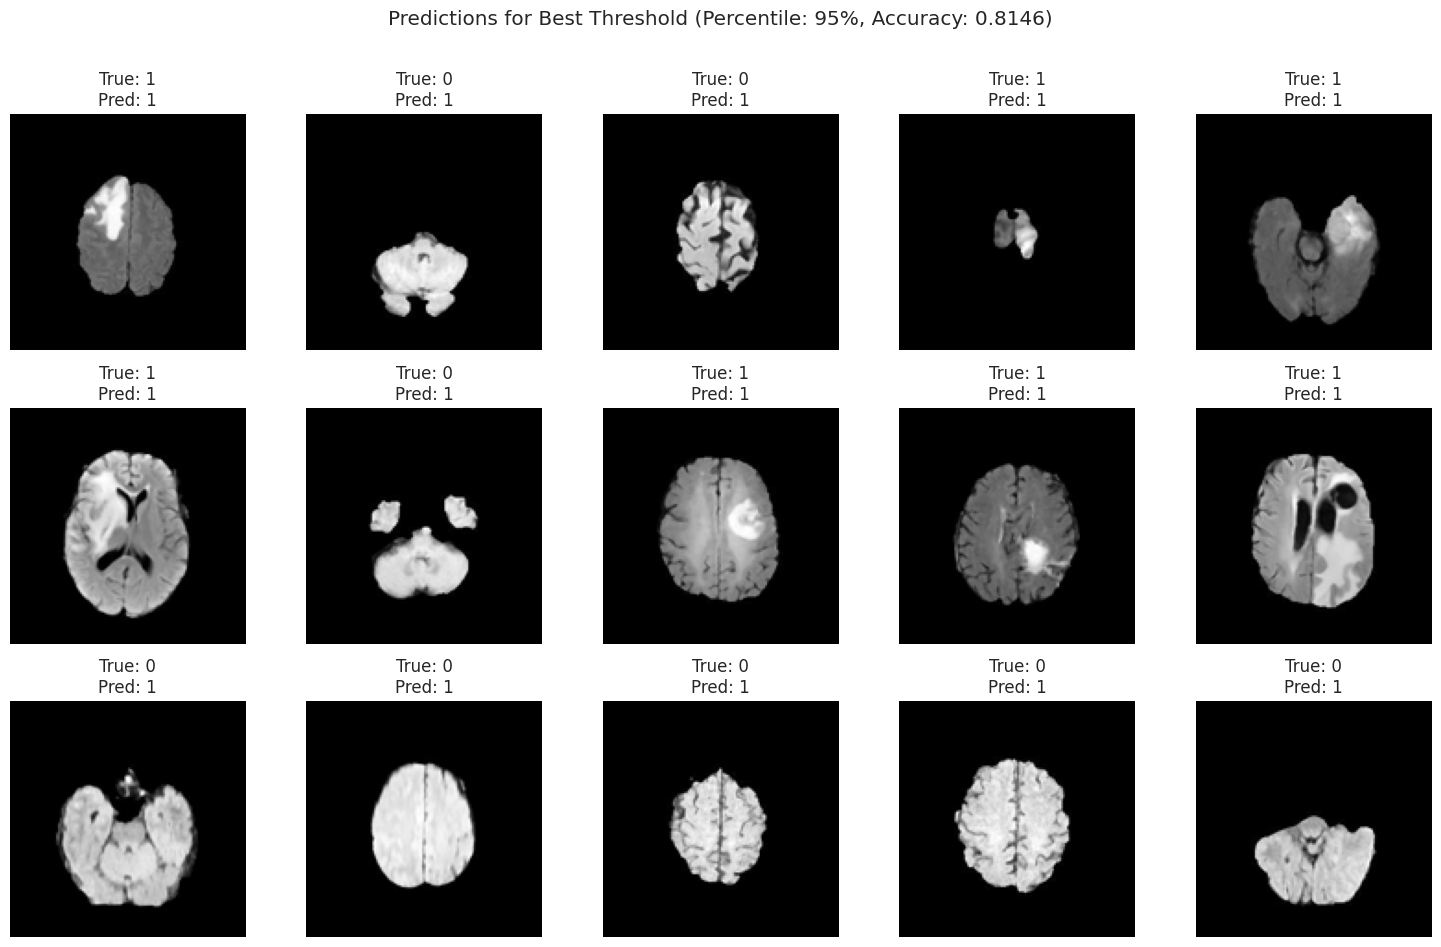

In [33]:
# Visualize predictions for the best result (15 images)
best_predictions = results[best_percentile]['predictions']
num_images_to_show = 15
indices = np.random.choice(len(test_images), num_images_to_show, replace=False)  # Randomly select 15 indices

plt.figure(figsize=(15, 9))
for i, idx in enumerate(indices):
    plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
    plt.imshow(test_images[idx].reshape(128, 128), cmap='gray')
    plt.title(f"True: {int(test_labels[idx])}\nPred: {best_predictions[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle(f"Predictions for Best Threshold (Percentile: {best_percentile_vae}%, Accuracy: {best_accuracy:.4f})", y=1.05)
plt.show()

## AE vs VAE comparision

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Analyzing: 100%|██████████| 100/100 [00:00<00:00, 533.29it/s]


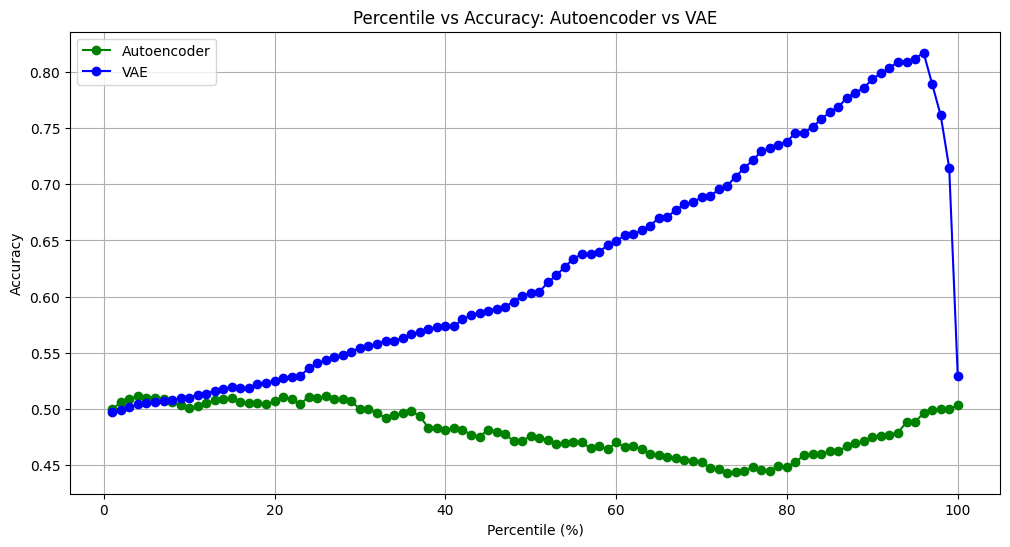

In [20]:

# Reconstruct test images using VAE's encoder and decoder
_, _, z = encoder.predict(test_images)  # Get latent representation
reconstructed_images = decoder.predict(z)  # Decode to reconstructions

# Compute reconstruction error (MSE) for each image
mse = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Compute training MSE for threshold calculation
_, _, train_z = encoder.predict(train_images)
train_reconstructed = decoder.predict(train_z)
train_mse = np.mean(np.square(train_images - train_reconstructed), axis=(1, 2, 3))

# Dictionary to store threshold and accuracy results
results_vae = {}

# Test thresholds from 1% to 100% with tqdm
for i in tqdm(range(100), desc="Analyzing"):
    percentile = 1 + i  # 1% to 100%
    threshold = np.percentile(train_mse, percentile)  # Percentile of Class 0 errors

    # Classify test images as normal (0) or anomalous (1) based on threshold
    predictions = (mse > threshold).astype(int)

    # Evaluate performance
    accuracy = accuracy_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)

    # Store results
    results_vae[percentile] = {
        'threshold': threshold,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix
    }

# Find the best result
best_percentile_vae = None
best_accuracy_vae = -1
for percentile, result in results_vae.items():
    if result['accuracy'] > best_accuracy_vae:
        best_accuracy_vae = result['accuracy']
        best_percentile_vae = percentile

# Plot percentile vs accuracy for VAE
percentiles_vae = list(results_vae.keys())  # [1, 2, ..., 100]
accuracies_vae = [results_vae[p]['accuracy'] for p in results_vae]
 # Combined plot for comparison
plt.figure(figsize=(12, 6))
plt.plot(percentiles_ae, accuracies_ae, marker='o', linestyle='-', color='g', label='Autoencoder')
plt.plot(percentiles_vae, accuracies_vae, marker='o', linestyle='-', color='b', label='VAE')
plt.title('Percentile vs Accuracy: Autoencoder vs VAE')
plt.xlabel('Percentile (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Heatmap comparision of best result from VAE vs AE

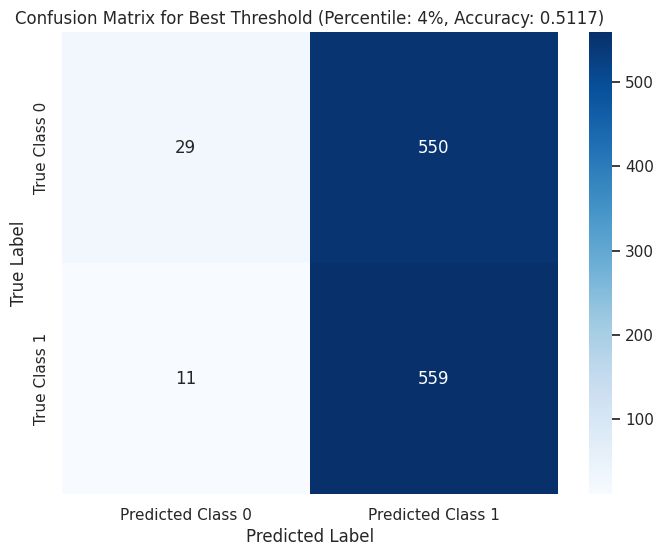

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(results[best_percentile]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Class 0', 'Predicted Class 1'],
            yticklabels=['True Class 0', 'True Class 1'])
plt.title(f'Confusion Matrix for Best Threshold (Percentile: {best_percentile}%, Accuracy: {best_accuracy:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

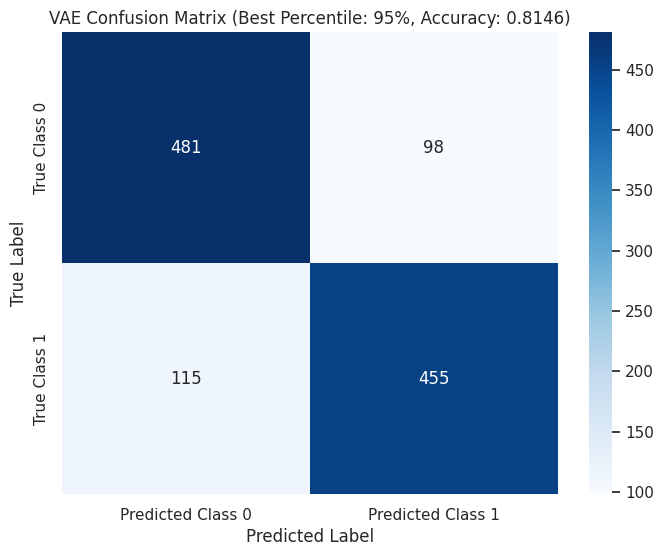

In [36]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(results[best_percentile_vae]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Class 0', 'Predicted Class 1'],
            yticklabels=['True Class 0', 'True Class 1'])
plt.title(f'VAE Confusion Matrix (Best Percentile: {best_percentile_vae}%, Accuracy: {best_accuracy:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()